# Refine labels for Monocytes

In this notebook, we load all CD14, Intermediate, and CD16 Monocytes across our subjects to refine final L3 labels. We'll combine, recluster, and assign final labels by taking the most frequent AIFI_L3 label in each cluster, and back-propogate those L3 labels to L2 and L1 based on our cell type hierarcy.

We'll also generate metadata, UMAP coordinates, and marker gene summaries for review of our final labels, then store all of the outputs in HISE for later use.

## Load packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from datetime import date
import hisepy
import os
import pandas as pd
import re
import scanpy as sc
import scanpy.external as sce
import tarfile

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
out_dir = 'output/review'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [4]:
class_name = 'monocyte'

## Helper functions

### HISE data
These functions make it easy to utilize files from the HISE cache

In [5]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [6]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [7]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [8]:
def read_obs_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    obs = res.obs.copy()
    return obs

### Label refinement

These functions uses the most frequent label within each cluster to refine label assignments.

In [9]:
def single_value(series):
    res = []
    for value in series:
        if isinstance(value, pd.core.arrays.categorical.Categorical) or isinstance(value, list):
            res.append(value[0])
        else:
            res.append(value)
    return res

In [10]:
def assign_most_frequent(adata, clusters, labels, keep_original = False, original_prefix = 'predicted_'):
    obs = adata.obs
    
    most_frequent_labels = (
        adata.obs
        .groupby(clusters)[labels]
        .agg(pd.Series.mode)
        .to_frame()
        .reset_index()
    )
    most_frequent_labels[labels] = single_value(most_frequent_labels[labels])
    
    if keep_original:
        obs = obs.rename({labels: original_prefix + labels}, axis = 1)
    else:
        obs = obs.drop(labels, axis = 1)
    
    obs = obs.merge(most_frequent_labels, on = clusters, how = 'left')
    
    adata.obs = obs
    
    return adata

These functions perform iterative analysis to refine some specific types:

In [11]:
def subset_refinement(adata, cluster_col, clusters, refine_res = 2):
    ref_adata = adata[adata.obs[cluster_col].isin(clusters)]
    ref_adata = process_adata(ref_adata, resolution = refine_res)
    ref_adata = assign_most_frequent(
        ref_adata, 
        'leiden_{r}'.format(r = refine_res), 'AIFI_L3',
        keep_original = True,
        original_prefix = 'predicted_'
    )
    
    ref_df = ref_adata.obs[['barcodes', 'AIFI_L3', 'predicted_AIFI_L3']]

    return ref_df

This function identifies CD14+/CD16+ clusters, and performs iterative clustering of these cells to improve labeling of Intermediate monocytes.

In [38]:
def cd16_refinement(adata, cluster_col = 'leiden_2', refine_res = 2):
    cd16_pos_cl = select_clusters_above_gene_frac(
        adata, 'FCGR3A', 0.2, clusters = cluster_col
    )
    c1qa_pos_cl = select_clusters_above_gene_frac(
        adata, 'C1QA', 0.6, clusters = cluster_col
    )
    sel_cl = set(cd16_pos_cl) - set(c1qa_pos_cl)
    sel_cl = list(sel_cl)
    print('CD16+/C1QA-: {c}'.format(c = sel_cl))
    print('CD16+/C1QA-: {n}'.format(n = str(sum(adata.obs[cluster_col].isin(sel_cl)))))
    if len(sel_cl) > 0:
        res = subset_refinement(
            adata, 
            cluster_col = cluster_col, 
            clusters = sel_cl, 
            refine_res = refine_res
        )
    else:
        res = pd.DataFrame({'barcodes': [''], 'AIFI_L3': [''], 'predicted_AIFI_L3': ['']})
    return res

This function can be used to update labels resulting from iterative subclustering.

In [13]:
def label_substitution(adata, labels):
    sub_idx = adata.obs['barcodes'].isin(labels['barcodes'])
    sub_adata = adata[sub_idx]
    
    adata = adata[[not x for x in sub_idx]]
    
    sub_obs = sub_adata.obs.drop(['AIFI_L3', 'predicted_AIFI_L3'], axis = 1)
    sub_obs = sub_obs.reset_index(drop = True)
    sub_obs = sub_obs.merge(labels, on = 'barcodes', how = 'left')
    sub_obs = sub_obs.set_index('barcodes', drop = False)
    sub_adata.obs = sub_obs
    
    adata = sc.concat([adata, sub_adata])
    return adata

This function back-propagates hierarchical labeling from AIFI_L3 back to AIFI_L2 and AIFI_L1 to ensure our labels agree across levels of our cell type hierarchy.

In [14]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
    
    adata.obs = obs

    return adata

### Review outputs

These functions are used to assemble marker gene expression tables for review

In [15]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def marker_mean_df(adata, markers, log = False, clusters = 'louvain_2'):
    gene_cl_mean = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True,
        log = log
    ).dot_color_df
    
    return gene_cl_mean

def tidy_marker_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, markers, clusters)
    gene_cl_frac = gene_cl_frac.reset_index(drop = False)
    gene_cl_frac = pd.melt(gene_cl_frac, id_vars = clusters, var_name = 'gene', value_name = 'gene_frac')
    
    gene_cl_mean = marker_mean_df(adata, markers, log = False, clusters = clusters)
    gene_cl_mean = gene_cl_mean.reset_index(drop = False)
    gene_cl_mean = pd.melt(gene_cl_mean, id_vars = clusters, var_name = 'gene', value_name = 'gene_mean')

    marker_df = gene_cl_frac.merge(gene_cl_mean, on = [clusters, 'gene'], how = 'left')
    return marker_df

This function will select clusters based on gene detection above a specifiec fraction of cells (cutoff).

In [16]:
def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

This function retrieves both observations and UMAP coordinates in a single table for review.

In [17]:
def obs_with_umap(adata):
    obs = adata.obs
    
    umap_mat = adata.obsm['X_umap']
    umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
    obs['umap_1'] = umap_df['umap_1']
    obs['umap_2'] = umap_df['umap_2']

    return obs

This function applies data analysis methods to our scRNA-seq data, including normalization, HVG selection, PCA, nearest neighbors, UMAP, and Leiden clustering.

In [18]:
def process_adata(adata, resolution = 3):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')

    print('Harmony', end = "; ")
    # Integrate subjects
    sce.pp.harmony_integrate(
        adata, 
        'subject.subjectGuid',
        max_iter_harmony = 30,
        verbose = False
    )
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30,
        use_rep = 'X_pca_harmony'
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

## Cell Type Markers

These are the set of marker genes that we'll use to review our cell type labels.

In [19]:
l2_markers = [
    'AXL', 'C1orf54', 'CD14', 'CD1C', 'CD74',
    'CDKN1C', 'CLEC9A', 'CST3', 'FCGR3A', 'HLA-DRA',
    'IL3RA', 'IRF8', 'ITM2C', 'PLAC8', 'S100A10',
    'S100A9', 'SIGLEC6', 'SPI1', 'VCAN'
]

l3_markers = [
    'AXL', 'C1QA', 'C1QB', 'C1orf54', 'CCL3',
    'CD14', 'CD163', 'CD1C', 'CD68', 'CD74',
    'CLEC9A', 'CST3', 'FCGR3A', 'GAPDH', 'HLA-DPA1',
    'HLA-DRA', 'IFI44L', 'IL1B', 'IL3RA', 'IRF8',
    'ISG15', 'ITM2C', 'MX1', 'NFKBIA', 'PLAC8',
    'S100A10', 'S100A8', 'S100A9', 'SIGLEC6', 'SMIM25',
    'SOD2', 'SPI1', 'VCAN'
]

## Read cell type hierarchy from HISE

As part of label refinement, we'll back-propagate our cell type labels from refined AIFI_L3 labels to their parent cell classes at AIFI_L2 and AIFI_L1. To do this, we need the hierarchical relationships between these levels, which have been generated for our cell type reference dataset.

In [20]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

downloading fileID: 1a44252c-8cab-4c8f-92c9-d8f3af633790
Files have been successfully downloaded!


## Identify files in HISE

For this analysis, we'll read in these files from HISE storage from previous steps. We'll group these into "large" files, which are from the set of 5 very large cell type assignments, and "small" files, which are from other cell types.

In [21]:
h5ad_uuids = {
    'BR1_Female_Negative_CD14-monocyte': 'beea5765-b3c0-4db1-a1c2-ada2ef51ee26',
    'BR1_Female_Positive_CD14-monocyte': '8496f50f-38f6-4f0d-a50c-0835268c42b5',
    'BR1_Male_Negative_CD14-monocyte': '6dfc083e-0392-438a-aa79-4b6c79acd55b',
    'BR1_Male_Positive_CD14-monocyte': '4f0d6c22-21d5-4410-b603-8b485487f42b',
    'BR2_Female_Negative_CD14-monocyte': '2906d91a-c989-4b1d-b343-aea2e23de036',
    'BR2_Female_Positive_CD14-monocyte': '42c2b3e1-f3ec-4a44-9137-3db3ead74454',
    'BR2_Male_Negative_CD14-monocyte': '47fff457-438f-46ba-ab37-9876bbbb1f18',
    'BR2_Male_Positive_CD14-monocyte': '41094c89-3ab0-43b8-a683-9b3b5a5b3653',
    'CD16-monocyte': '39cb92e1-8053-4607-8fe8-a6dd8632b32a',
    'Intermediate-monocyte': 'c7bb1b35-03b4-4acb-bb52-b75a0c5efcdf'
}

## Read and process data

In [22]:
out_file = 'output/diha_{c}_AIFI_L3_review_{d}.h5ad'.format(c = class_name, d = date.today())
out_review = []

adata_list = []
for group_name, uuid in h5ad_uuids.items():
    group_adata = read_adata_uuid(uuid)
    print('{g}: {n} cells'.format(g = group_name, n = group_adata.shape[0]))
    adata_list.append(group_adata)
    
adata = sc.concat(adata_list)
print('Total: {n} cells'.format(n = adata.shape[0]))
del adata_list

downloading fileID: beea5765-b3c0-4db1-a1c2-ada2ef51ee26
Files have been successfully downloaded!
BR1_Female_Negative_CD14-monocyte: 369773 cells
downloading fileID: 8496f50f-38f6-4f0d-a50c-0835268c42b5
Files have been successfully downloaded!
BR1_Female_Positive_CD14-monocyte: 178482 cells
downloading fileID: 6dfc083e-0392-438a-aa79-4b6c79acd55b
Files have been successfully downloaded!
BR1_Male_Negative_CD14-monocyte: 285635 cells
downloading fileID: 4f0d6c22-21d5-4410-b603-8b485487f42b
Files have been successfully downloaded!
BR1_Male_Positive_CD14-monocyte: 162354 cells
downloading fileID: 2906d91a-c989-4b1d-b343-aea2e23de036
Files have been successfully downloaded!
BR2_Female_Negative_CD14-monocyte: 194754 cells
downloading fileID: 42c2b3e1-f3ec-4a44-9137-3db3ead74454
Files have been successfully downloaded!
BR2_Female_Positive_CD14-monocyte: 364420 cells
downloading fileID: 47fff457-438f-46ba-ab37-9876bbbb1f18
Files have been successfully downloaded!
BR2_Male_Negative_CD14-monocyt

In [23]:
adata = process_adata(adata, resolution = 3)

Normalizing; Finding HVGs; Scaling; PCA; Harmony; 

2024-04-04 23:55:10,351 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-05 00:05:20,038 - harmonypy - INFO - sklearn.KMeans initialization complete.


Neighbors; Leiden; UMAP; Renormalizing


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


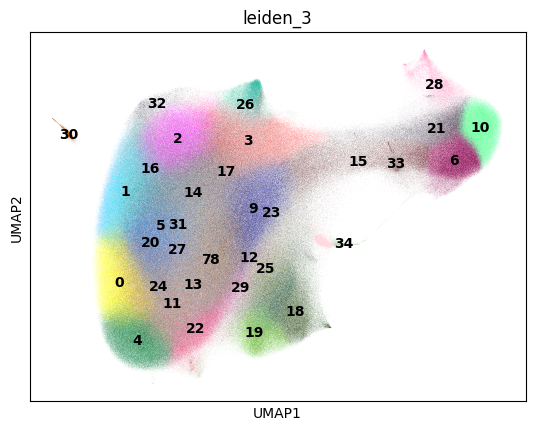

In [24]:
sc.pl.umap(adata, color = 'leiden_3', legend_loc = 'on data')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


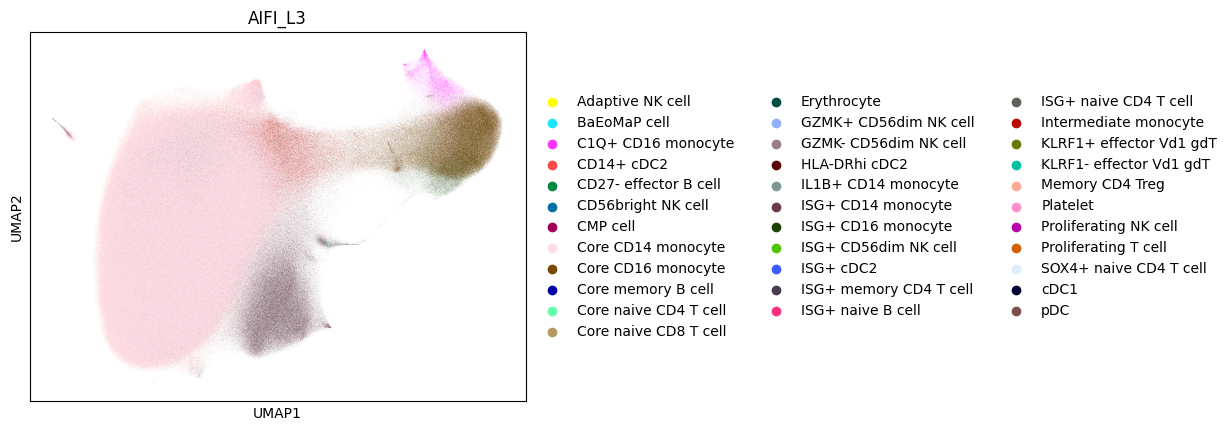

In [25]:
sc.pl.umap(adata, color = 'AIFI_L3')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


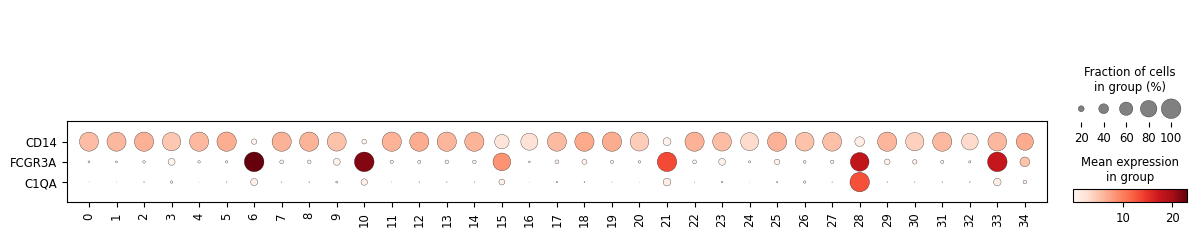

In [26]:
sc.pl.dotplot(
    adata,
    groupby = 'leiden_3',
    var_names = ['CD14','FCGR3A','C1QA'],
    swap_axes = True
)

In [40]:
# Subcluster to refine Intermediate Monocytes
cd16_labels = cd16_refinement(
    adata,
    cluster_col = 'leiden_3',
    refine_res = 1
)

CD16+/C1QA-: ['6', '3', '33', '21', '9', '23', '34', '15', '10']
CD16+/C1QA-: 640423


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Normalizing; Finding HVGs; Scaling; PCA; Harmony; 

2024-04-05 22:46:22,405 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-05 22:51:08,620 - harmonypy - INFO - sklearn.KMeans initialization complete.


Neighbors; Leiden; UMAP; Renormalizing


In [41]:
cd16_labels['AIFI_L3'].value_counts()

AIFI_L3
Core CD16 monocyte       308858
Core CD14 monocyte       218630
Intermediate monocyte     76973
ISG+ CD16 monocyte        32673
IL1B+ CD14 monocyte        3289
Name: count, dtype: int64

In [42]:
# Refine labels based on in-group clustering
adata = assign_most_frequent(
    adata, 
    'leiden_3', 'AIFI_L3', 
    keep_original = True, 
    original_prefix = 'predicted_'
)

In [43]:
# Inject intermediate labels
adata = label_substitution(adata, cd16_labels)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [44]:
visit_group_adata = propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
)

In [45]:
adata.obs['predicted_AIFI_L3'].value_counts()

predicted_AIFI_L3
Core CD14 monocyte         1750599
ISG+ CD14 monocyte          292241
Core CD16 monocyte          278916
Intermediate monocyte        74939
ISG+ CD16 monocyte           38123
C1Q+ CD16 monocyte           31423
IL1B+ CD14 monocyte          22761
CD14+ cDC2                    2504
ISG+ cDC2                      790
GZMK- CD56dim NK cell          523
HLA-DRhi cDC2                  231
Platelet                       125
ISG+ CD56dim NK cell            75
Core naive CD4 T cell           48
Erythrocyte                     39
ISG+ memory CD4 T cell          25
ISG+ naive B cell               24
ISG+ naive CD4 T cell           18
CMP cell                        11
CD56bright NK cell              10
Proliferating NK cell            6
pDC                              6
KLRF1- effector Vd1 gdT          3
Adaptive NK cell                 3
GZMK+ CD56dim NK cell            2
cDC1                             2
BaEoMaP cell                     1
Core naive CD8 T cell            1
KL

In [46]:
adata.obs['AIFI_L3'].value_counts()

AIFI_L3
Core CD14 monocyte       1773685
Core CD16 monocyte        308858
ISG+ CD14 monocyte        268729
Intermediate monocyte      76973
ISG+ CD16 monocyte         32673
C1Q+ CD16 monocyte         29248
IL1B+ CD14 monocyte         3289
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


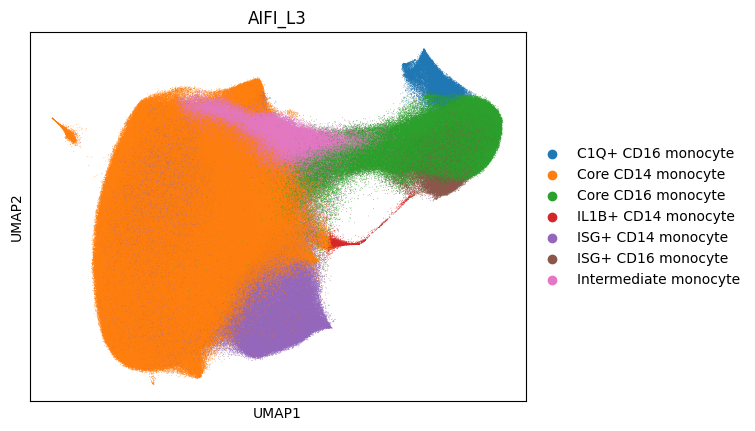

In [53]:
sc.pl.umap(adata, color = 'AIFI_L3', size = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


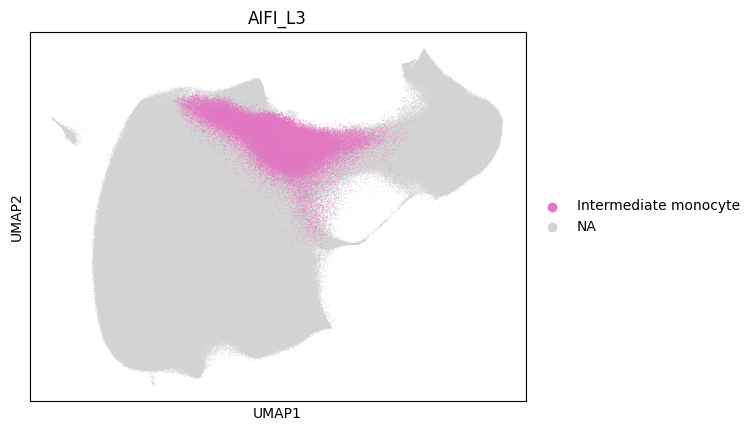

In [47]:
sc.pl.umap(adata, color = 'AIFI_L3', groups = 'Intermediate monocyte', size = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


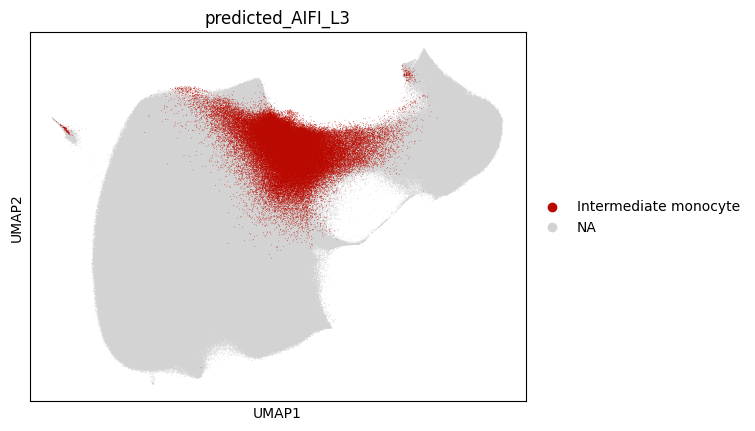

In [52]:
sc.pl.umap(adata, color = 'predicted_AIFI_L3', groups = 'Intermediate monocyte', size = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


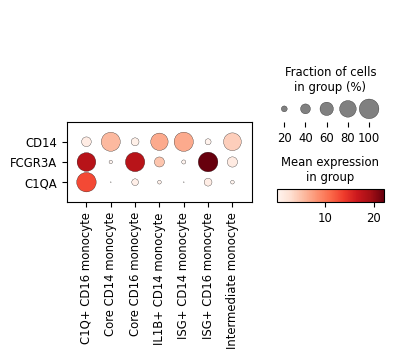

In [48]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L3',
    var_names = ['CD14','FCGR3A','C1QA'],
    swap_axes = True
)

In [54]:
# Save results for this visit group
adata.write_h5ad(out_file)

In [57]:
# Save metadata and UMAP
meta_csv = 'output/review/diha_{c}_AIFI_L3_review_meta_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
visit_group_obs = obs_with_umap(adata)
visit_group_obs.to_csv(meta_csv)
out_review.append(meta_csv)

# Save marker expression summaries
out_l2_markers = 'output/review/diha_{c}_AIFI_L2_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l2_marker_df = tidy_marker_df(
    adata,
    l2_markers,
    'AIFI_L2'
)
l2_marker_df.to_csv(out_l2_markers)
out_review.append(out_l2_markers)

out_l3_markers = 'output/review/diha_{c}_AIFI_L3_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l3_marker_df = tidy_marker_df(
    adata,
    l3_markers,
    'AIFI_L3'
)
l3_marker_df.to_csv(out_l3_markers)
out_review.append(out_l3_markers)

## Assemble output files for upload

### h5ad files

In [58]:
h5ad_files = [out_file]

### Review files

In [59]:
rev_files = os.listdir('output/review')
review_files = []
for rev_file in rev_files:
    if class_name in rev_file:
        review_files.append('{d}/{f}'.format(d = 'output/review', f = rev_file))

### Combine metadata files to assemble a full set

In [60]:
meta_files = []
for review_file in review_files:
    if 'meta' in review_file:
        meta_files.append(review_file)

meta_list = []
for meta_file in meta_files:
    meta_list.append(pd.read_csv(meta_file, index_col = 0))
all_meta = pd.concat(meta_list)

In [61]:
meta_csv = 'output/diha_{c}_AIFI_L3_refinement_meta_{d}.csv'.format(c = class_name, d = date.today())
all_meta.to_csv(meta_csv)
meta_parquet = 'output/diha_{c}_AIFI_L3_refinement_meta_{d}.parquet'.format(c = class_name, d = date.today())
all_meta.to_parquet(meta_parquet)

### Bundle review files into a .tar for later use

In [62]:
review_tar = 'output/diha_{c}_AIFI_L3_refinement_review_{d}.tar.gz'.format(c = class_name, d = date.today())
tar = tarfile.open(review_tar, 'w:gz')
for review_file in review_files:
    tar.add(review_file)
tar.close()

## Upload assembled results to HISE

In [63]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA Monocyte AIFI_L3 Label-based refinement {d}'.format(d = date.today())

In [65]:
in_files = []
for group_name, uuid in h5ad_uuids.items():
    in_files.append(uuid)
in_files

['beea5765-b3c0-4db1-a1c2-ada2ef51ee26',
 '8496f50f-38f6-4f0d-a50c-0835268c42b5',
 '6dfc083e-0392-438a-aa79-4b6c79acd55b',
 '4f0d6c22-21d5-4410-b603-8b485487f42b',
 '2906d91a-c989-4b1d-b343-aea2e23de036',
 '42c2b3e1-f3ec-4a44-9137-3db3ead74454',
 '47fff457-438f-46ba-ab37-9876bbbb1f18',
 '41094c89-3ab0-43b8-a683-9b3b5a5b3653',
 '39cb92e1-8053-4607-8fe8-a6dd8632b32a',
 'c7bb1b35-03b4-4acb-bb52-b75a0c5efcdf']

In [66]:
out_files = h5ad_files + [meta_csv, meta_parquet, review_tar]

In [67]:
out_files

['output/diha_monocyte_AIFI_L3_review_2024-04-04.h5ad',
 'output/diha_monocyte_AIFI_L3_refinement_meta_2024-04-06.csv',
 'output/diha_monocyte_AIFI_L3_refinement_meta_2024-04-06.parquet',
 'output/diha_monocyte_AIFI_L3_refinement_review_2024-04-06.tar.gz']

In [68]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = 'mono_label_refinement'
)

output/diha_monocyte_AIFI_L3_review_2024-04-04.h5ad
output/diha_monocyte_AIFI_L3_refinement_meta_2024-04-06.csv
output/diha_monocyte_AIFI_L3_refinement_meta_2024-04-06.parquet
output/diha_monocyte_AIFI_L3_refinement_review_2024-04-06.tar.gz
you are trying to upload file_ids... ['output/diha_monocyte_AIFI_L3_review_2024-04-04.h5ad', 'output/diha_monocyte_AIFI_L3_refinement_meta_2024-04-06.csv', 'output/diha_monocyte_AIFI_L3_refinement_meta_2024-04-06.parquet', 'output/diha_monocyte_AIFI_L3_refinement_review_2024-04-06.tar.gz']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'c0ae845d-9854-4115-86fd-8f4179e84651',
 'files': ['output/diha_monocyte_AIFI_L3_review_2024-04-04.h5ad',
  'output/diha_monocyte_AIFI_L3_refinement_meta_2024-04-06.csv',
  'output/diha_monocyte_AIFI_L3_refinement_meta_2024-04-06.parquet',
  'output/diha_monocyte_AIFI_L3_refinement_review_2024-04-06.tar.gz']}

In [69]:
import session_info
session_info.show()